In [246]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [247]:
## https://drive.google.com/file/d/1XD3O5Sv31jDp6xcgoMgSk5fpVqxsn0ed/view?usp=sharing
tracks_spotify_filter_df = pd.read_csv('../sandbox/tracks_features_with_genres_100k.csv.gz')
tracks_spotify_filter_df.head()

,audio_features.danceability,audio_features.energy,audio_features.key,audio_features.loudness,audio_features.mode,audio_features.speechiness,audio_features.acousticness,audio_features.instrumentalness,audio_features.liveness,audio_features.valence,audio_features.tempo,track_uri,artists.genres
0,0.655,0.628,11.0,-6.935,0.0,0.0362,0.107,0.000000,0.165,0.381,142.345,spotify:track:12E2p0RqVHMyf37og39cNR,"['greek pop', 'laiko']"
1,0.679,0.656,11.0,-8.710,1.0,0.0279,0.191,0.022000,0.124,0.834,101.955,spotify:track:51TbglSR7W8J58a1Nuj46g,['new wave pop']
2,0.679,0.656,11.0,-8.710,1.0,0.0279,0.191,0.022000,0.124,0.834,101.955,spotify:track:51TbglSR7W8J58a1Nuj46g,['new wave pop']
3,0.679,0.656,11.0,-8.710,1.0,0.0279,0.191,0.022000,0.124,0.834,101.955,spotify:track:51TbglSR7W8J58a1Nuj46g,['new wave pop']
4,0.477,0.177,5.0,-14.837,1.0,0.0327,0.813,0.000113,0.110,0.273,144.959,spotify:track:2juOBckXuHwbOJtwtYEzTr,"['australian alternative rock', 'australian po..."


In [191]:
tracks_spotify_filter_np = StandardScaler().fit_transform(tracks_spotify_filter_df.iloc[:, :11])

array([[ 0.29213159, -0.08616997,  1.60634519, ..., -0.15820807,
        -0.46267094,  0.72805064],
       [ 0.4392906 ,  0.04705931,  1.60634519, ..., -0.42167521,
         1.41170875, -0.67679616],
       [ 0.4392906 ,  0.04705931,  1.60634519, ..., -0.42167521,
         1.41170875, -0.67679616],
       ...,
       [ 0.66616073, -1.63733938, -0.87864342, ..., -0.46023138,
        -0.00338585, -1.09247639],
       [ 0.66616073, -1.63733938, -0.87864342, ..., -0.46023138,
        -0.00338585, -1.09247639],
       [-2.80433915, -2.81070863, -0.32642372, ..., -0.52449165,
        -1.90466061,  0.57890523]])

## Modelo (AutoEncoder)

In [162]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [163]:
# Se crea la clase autoencoder.
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 8),
            nn.ReLU(),
            nn.Linear(8, 10),
            nn.ReLU(),
            nn.Linear(10, 11))
        
    def predict(self, data):
        return self.encoder(data)

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return decoder 

In [164]:
# Se crea la clase GenerateDataset para leer los datos.
class GenerateDataset(Dataset):
    def __init__(self, numpy_array):
        self.numpy_array = numpy_array

    def __len__(self):
        return len(self.numpy_array)

    def __getitem__(self, idx):
        data = self.numpy_array[idx]
        x = np.isnan(data)
        data[x] = 0
        return data

### Hiperparametros

In [244]:
learning_rate = 0.01
epochs = 1
batch_size = 256
device = "cuda:0" # "cpu"

train_data = DataLoader(GenerateDataset(tracks_spotify_filter_np.astype('f')), # Valores de numpy en float.
            batch_size=batch_size,
            shuffle=False)

### Entrenamiento

In [245]:
model = autoencoder().to(device) # GPU -> ON
criterion = nn.MSELoss() # Error Cuadrático Medio 
optimizer = torch.optim.Adam( # Optimizador, en este caso Adam (puede ser SGD tmbn)
    model.parameters(), lr=learning_rate, weight_decay=1e-8)

for epoch in range(epochs):
    for data in tqdm(train_data):
        data = data.to(device)
        optimizer.zero_grad()
        
        # forward
        output = model(data)
        loss = criterion(output, data)
        
        # backward
        loss.backward()
        optimizer.step()
    res = 'Loss: {:.4f}, epoch: [{}/{}]'.format(loss, epoch + 1, epochs)
    tqdm.write(res)

100%|██████████| 26716/26716 [01:12<00:00, 370.72it/s]

Loss: 0.5353, epoch: [1/1]


In [169]:
# Se guarda el modelo.
torch.save(model.state_dict(), './modelo_150e_256b_decay_l032.pth')

Una vez entrenado el modelo, utilizamos solo el encoder del modelo para pasar de 11 dimensiones a 2. Es decir, pasaremos las features de las canciones por la red y guardaremos el output reordenado por el autoencoder (espacio latente).

In [192]:
## En el caso de tener un modelo entrenado...
## Modelo guardado: https://drive.google.com/file/d/1-zJ01kfBQyixf9YiKuzFSgTYEReJFAQl/view?usp=sharing
model = autoencoder().cuda()
model.load_state_dict(torch.load('/home/chr/Desktop/CC5205-3-proyecto/sandbox/modelo_150e_256b_decay.pth'))

<All keys matched successfully>

In [202]:
cantidad = 100000 # Las primeras X canciones (para no estar 10 años)
features = DataLoader(GenerateDataset(tracks_spotify_filter_np[:cantidad].astype('f')),
            batch_size=1,
            shuffle=False)

In [203]:
resultado_espacio_latente = []
for data in tqdm(features):
    data = data.cuda()
    resultado_espacio_latente.append(model.predict(data).detach().cpu().numpy()[0])


100%|██████████| 100000/100000 [00:25<00:00, 3932.60it/s]


In [204]:
df_espacio_latente = pd.DataFrame(resultado_espacio_latente, columns = ['comp_1','comp_2'])
df_espacio_latente = df_espacio_latente.assign(id=tracks_spotify_filter_df['track_uri'])
df_espacio_latente = df_espacio_latente.assign(genres=tracks_spotify_filter_df['artists.genres'])
df_espacio_latente = df_espacio_latente.drop_duplicates(subset=['id'], keep='last')
df_espacio_latente.head()

,comp_1,comp_2,id,genres
0,-1.909671,1.968510,spotify:track:12E2p0RqVHMyf37og39cNR,"['greek pop', 'laiko']"
3,0.791293,0.605486,spotify:track:51TbglSR7W8J58a1Nuj46g,['new wave pop']
17,2.949859,0.185543,spotify:track:2juOBckXuHwbOJtwtYEzTr,"['australian alternative rock', 'australian po..."
18,1.474414,0.819759,spotify:track:2asuLi0NXVqPmBWjqfFq4Y,"['brill building pop', 'bubblegum pop', 'class..."
19,1.942428,0.765149,spotify:track:4nDPvtN0zAwDgiB1k75TOh,"['pub rock', 'roots rock']"


In [242]:
# Hay artistas que no tienen genero musical -> []
fig = px.scatter(df_espacio_latente, x='comp_1', y='comp_2', custom_data=['id','genres'])
fig.update_traces(
    hovertemplate="<br> Artista: %{customdata[0]}" + "<br> Generos: %{customdata[1]}"
)
fig.show()

### Pruebas de recomendacion con 2k playlists.

In [206]:
playlists = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/2000_spotify_sample.csv.gz')

/home/chr/tmp/dl/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [207]:
tracks = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/tracks_features/2000_tracks_sample.csv.gz')
tracks.columns=[col[15:] if col[:15]=="audio_features." else col for col in tracks.columns]
tracks.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.628,0.870,5,-5.752,0,0.1080,0.01970,0.000000,0.118,0.8500,170.686,audio_features,5QxbGa4K41SPmY8zeyRs67,spotify:track:5QxbGa4K41SPmY8zeyRs67,https://api.spotify.com/v1/tracks/5QxbGa4K41SP...,https://api.spotify.com/v1/audio-analysis/5Qxb...,227747,4
1,0.303,0.401,2,-13.932,1,0.0375,0.02280,0.768000,0.113,0.0974,155.822,audio_features,4y0Lt1KOuyhKGkGKFZjSlS,spotify:track:4y0Lt1KOuyhKGkGKFZjSlS,https://api.spotify.com/v1/tracks/4y0Lt1KOuyhK...,https://api.spotify.com/v1/audio-analysis/4y0L...,205333,4
2,0.830,0.508,5,-6.070,1,0.0613,0.02910,0.000000,0.240,0.7970,95.051,audio_features,265yhmmWClZfBmgNPzwOMP,spotify:track:265yhmmWClZfBmgNPzwOMP,https://api.spotify.com/v1/tracks/265yhmmWClZf...,https://api.spotify.com/v1/audio-analysis/265y...,195740,4
3,0.907,0.465,5,-7.123,0,0.2880,0.01750,0.000015,0.117,0.1880,141.957,audio_features,4ibj6HRTdzkfvlDgxSXxCp,spotify:track:4ibj6HRTdzkfvlDgxSXxCp,https://api.spotify.com/v1/tracks/4ibj6HRTdzkf...,https://api.spotify.com/v1/audio-analysis/4ibj...,211692,4
4,0.296,0.852,4,-5.095,1,0.0439,0.00113,0.678000,0.141,0.5840,160.119,audio_features,6ZJyUCbGB4FFIuI8jiuafp,spotify:track:6ZJyUCbGB4FFIuI8jiuafp,https://api.spotify.com/v1/tracks/6ZJyUCbGB4FF...,https://api.spotify.com/v1/audio-analysis/6ZJy...,307050,4


In [212]:
df = playlists.merge(tracks, left_on='track_uri', right_on='uri', how='inner')
df = df.drop_duplicates(subset=['uri'], keep='last')
df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms_x,num_artists,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature
3,snowboarding,False,874521,1483056000,93,51,1,2,219480,30,...,0.365,0.645,93.008,audio_features,0y8Wf6ltWpGCpgqVa21QNX,spotify:track:0y8Wf6ltWpGCpgqVa21QNX,https://api.spotify.com/v1/tracks/0y8Wf6ltWpGC...,https://api.spotify.com/v1/audio-analysis/0y8W...,219480,4
59,Essential,False,973521,1509062400,222,164,1,118,247160,111,...,0.164,0.446,103.019,audio_features,6RUKPb4LETWmmr3iAEQktW,spotify:track:6RUKPb4LETWmmr3iAEQktW,https://api.spotify.com/v1/tracks/6RUKPb4LETWm...,https://api.spotify.com/v1/audio-analysis/6RUK...,247160,4
75,alternative,False,975521,1506556800,142,95,1,42,223846,58,...,0.104,0.594,81.019,audio_features,1sYSP7gKa5kdKIfhANfori,spotify:track:1sYSP7gKa5kdKIfhANfori,https://api.spotify.com/v1/tracks/1sYSP7gKa5kd...,https://api.spotify.com/v1/audio-analysis/1sYS...,223847,4
163,XO TOUR Llif3,False,996737,1505779200,23,18,1,5,220293,15,...,0.253,0.492,123.146,audio_features,3a1lNhkSLSkpJE4MSHpDu9,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,https://api.spotify.com/v1/tracks/3a1lNhkSLSkp...,https://api.spotify.com/v1/audio-analysis/3a1l...,220293,4
191,Top hits,False,990521,1498176000,22,21,1,6,201160,20,...,0.184,0.678,123.980,audio_features,3E2Zh20GDCR9B1EYjfXWyv,spotify:track:3E2Zh20GDCR9B1EYjfXWyv,https://api.spotify.com/v1/tracks/3E2Zh20GDCR9...,https://api.spotify.com/v1/audio-analysis/3E2Z...,201160,4


In [213]:
df = df.groupby('pid').mean().reset_index()

In [214]:
features_by_pid = df[['pid','danceability', 'energy', 'key', 'loudness', 'mode',
                      'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                      'valence', 'tempo']]
features_by_pid_np = StandardScaler().fit_transform(features_by_pid.iloc[:, 1:])

In [216]:
test_data = DataLoader(GenerateDataset(features_by_pid_np.astype('f')), # Valores de numpy en float.
            batch_size=1,
            shuffle=False)

In [217]:
# Todas las canciones de las 2k playlist son pasadas por el .encoder
resultado_test = []
for data in tqdm(test_data):
    data = data.cuda()
    resultado_test.append(model.predict(data).detach().cpu().numpy()[0])

100%|██████████| 1935/1935 [00:00<00:00, 3694.91it/s]


In [218]:
df_test = pd.DataFrame(resultado_test, columns = ['comp_1','comp_2'])
df_test = df_test.assign(id=features_by_pid['pid'])
df_test.head()

,comp_1,comp_2,id
0,0.746889,-0.050473,521
1,1.903157,10.771100,737
2,0.913378,-0.940957,1521
3,-2.852277,13.178306,1737
4,0.434216,11.046635,2521


En la imagen se grafican 20 puntos, lo que corresponde a la posición de sus tracks_features promedio. Así podríamos recomendar las X canciones más similares (en base a su cercanía o con otro método) a la playlist.

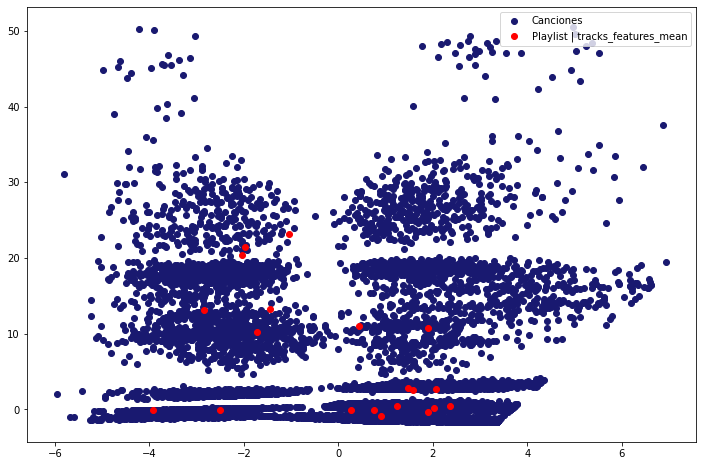

In [239]:
# Se grafican las 20 playlist pasando por el modelo.
plt.figure(figsize=(12,8))
plt.scatter(df_espacio_latente['comp_1'], df_espacio_latente['comp_2'], c="midnightblue", label="Canciones")
plt.scatter(df_test['comp_1'][:20], df_test['comp_2'][:20], c='red', label="Playlist | tracks_features_mean")
plt.legend()

In [240]:
# Se toma la primera playlist (pid 521) y se pasa a tensor.
playlist_input = torch.tensor(df_test.iloc[:1,:2].to_numpy())
# df_espacio_latente son todas las canciones (o parte) procesadas por .encoder (espacio latente).
dataset_latente = torch.tensor(df_espacio_latente.iloc[:,:2].to_numpy())
# Se buscan las canciones mas cercanas a la playlist 521
result_cdist = torch.cdist(playlist_input, dataset_latente, p=2)
# Se ordenan los valores.
result_cdist_sort = [x.item() for x in np.argsort(result_cdist)[0]]
# Se muestran las 100 canciones mas cercana a la playlist 521
df_espacio_latente.iloc[result_cdist_sort[:100]]

,comp_1,comp_2,id,genres
28632,0.728990,0.033983,spotify:track:3njZlgsB9MI6DVTg8wDPsg,"['celtic rock', 'dance pop', 'modern rock', 'n..."
11884,0.813787,-0.105428,spotify:track:6GZGlwHSHH3o9NdTF4auVZ,"['country', 'country rock', 'outlaw country', ..."
52958,0.711487,0.029148,spotify:track:1sjP6WHuidsDYhTOg6KOCf,"['alternative rock', 'grunge', 'minneapolis pu..."
98309,0.785141,0.045665,spotify:track:1slGjcxBJEfM8ehEsLvWF0,"['dance pop', 'edm', 'electropop', 'pop', 'pop..."
43767,0.759509,0.053271,spotify:track:0oZI039wVNZr4lLrt6y6B4,"['adult standards', 'neo classical metal', 'pr..."
...,...,...,...,...
55003,1.013981,-0.044372,spotify:track:27cPmL8Edw13g4IqzHyesE,"['britpop', 'madchester', 'new wave', 'permane..."
8377,0.975960,0.089444,spotify:track:7tPfuSJ5NlV2ZtnPAhwx2V,['new americana']
75485,0.552169,0.135837,spotify:track:1lkaByCqk9Ue3vEXWOJCQd,"['ccm', 'christian alternative rock', 'christi..."
24110,0.869616,0.190334,spotify:track:2aV8vBbVYeRbkPMK8bhxm9,"['chopped and screwed', 'houston rap']"


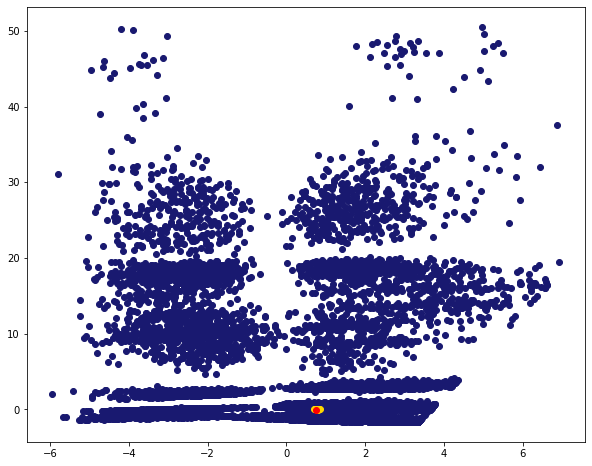

In [252]:
# Se grafica todo lo anterior.
plt.figure(figsize=(10,8))
plt.scatter(df_espacio_latente['comp_1'], df_espacio_latente['comp_2'],c='midnightblue')
plt.scatter(df_espacio_latente.iloc[test[:10], 0], df_espacio_latente.iloc[test[:10], 1], c='gold')
plt.scatter(df_test.iloc[:1,0], df_test.iloc[:1,1], c='red')